In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from datetime import datetime

# 设置中文字体显示
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [4]:
# 1.数据加载

# 使用原始字符串避免转义问题
file_path = r'C:\Users\admin\Desktop\basketball.xlsx'
df = pd.read_excel(file_path)
print("数据加载成功，共有", df.shape[0], "行，", df.shape[1], "列。")
print("\n数据信息展示：")
df

数据加载成功，共有 287 行， 10 列。

数据信息展示：


,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes
0,Tue Oct 17 2017,8:01p,Boston Celtics,99,Cleveland Cavaliers,102,Box Score,NaN,20562.0,NaN
1,Tue Oct 17 2017,10:30p,Houston Rockets,122,Golden State Warriors,121,Box Score,NaN,19596.0,NaN
2,Wed Oct 18 2017,7:00p,Charlotte Hornets,90,Detroit Pistons,102,Box Score,NaN,20491.0,NaN
3,Wed Oct 18 2017,7:00p,Brooklyn Nets,131,Indiana Pacers,140,Box Score,NaN,15008.0,NaN
4,Wed Oct 18 2017,7:00p,Miami Heat,109,Orlando Magic,116,Box Score,NaN,18846.0,NaN
...,...,...,...,...,...,...,...,...,...,...
282,Fri Oct 2 2020,9:00p,Miami Heat,114,Los Angeles Lakers,124,Box Score,NaN,NaN,NaN
283,Sun Oct 4 2020,7:30p,Los Angeles Lakers,104,Miami Heat,115,Box Score,NaN,NaN,NaN
284,Tue Oct 6 2020,9:00p,Los Angeles Lakers,102,Miami Heat,96,Box Score,NaN,NaN,NaN
285,Fri Oct 9 2020,9:00p,Miami Heat,111,Los Angeles Lakers,108,Box Score,NaN,NaN,NaN


In [6]:
#类别  对应列名	示例解释
#比赛日期	Date	2017年10月17日（星期二）
#比赛双方	Visitor/Neutral、Home/Neutral	客场队（凯尔特人）vs 主场队（骑士）
#比赛得分	Visitor/Neutral PTS、Home/Neutral PTS	凯尔特人99分，骑士102分
#其他信息	Start (ET)、Attend.、Box Score	比赛时间、观众人数、技术统计链接

In [8]:
# 2.数据清洗
# (1)重命名列
new_columns = [
    'Date', 'Start (ET)', 'Visitor_Team', 'Visitor_PTS', 
    'Home_Team', 'Home_PTS', 'Box_Score', 'Unnamed_6', 'Attend', 'Notes'
]
df.columns = new_columns
print("\n=== 重命名列后 ===")
print("新列名：", df.columns.tolist())
display(df.head())


=== 重命名列后 ===
新列名： ['Date', 'Start (ET)', 'Visitor_Team', 'Visitor_PTS', 'Home_Team', 'Home_PTS', 'Box_Score', 'Unnamed_6', 'Attend', 'Notes']


,Date,Start (ET),Visitor_Team,Visitor_PTS,Home_Team,Home_PTS,Box_Score,Unnamed_6,Attend,Notes
0,Tue Oct 17 2017,8:01p,Boston Celtics,99,Cleveland Cavaliers,102,Box Score,NaN,20562.0,NaN
1,Tue Oct 17 2017,10:30p,Houston Rockets,122,Golden State Warriors,121,Box Score,NaN,19596.0,NaN
2,Wed Oct 18 2017,7:00p,Charlotte Hornets,90,Detroit Pistons,102,Box Score,NaN,20491.0,NaN
3,Wed Oct 18 2017,7:00p,Brooklyn Nets,131,Indiana Pacers,140,Box Score,NaN,15008.0,NaN
4,Wed Oct 18 2017,7:00p,Miami Heat,109,Orlando Magic,116,Box Score,NaN,18846.0,NaN


In [10]:
# (2)删除无用列
cols_to_drop = ['Box_Score', 'Unnamed_6', 'Notes']
df = df.drop(cols_to_drop, axis=1)
print("\n=== 删除无用列后 ===")
print(f"剩余列名：{df.columns.tolist()}")
print(f"数据维度：{df.shape[0]} 行, {df.shape[1]} 列")
display(df.head())


=== 删除无用列后 ===
剩余列名：['Date', 'Start (ET)', 'Visitor_Team', 'Visitor_PTS', 'Home_Team', 'Home_PTS', 'Attend']
数据维度：287 行, 7 列


,Date,Start (ET),Visitor_Team,Visitor_PTS,Home_Team,Home_PTS,Attend
0,Tue Oct 17 2017,8:01p,Boston Celtics,99,Cleveland Cavaliers,102,20562.0
1,Tue Oct 17 2017,10:30p,Houston Rockets,122,Golden State Warriors,121,19596.0
2,Wed Oct 18 2017,7:00p,Charlotte Hornets,90,Detroit Pistons,102,20491.0
3,Wed Oct 18 2017,7:00p,Brooklyn Nets,131,Indiana Pacers,140,15008.0
4,Wed Oct 18 2017,7:00p,Miami Heat,109,Orlando Magic,116,18846.0


In [12]:
# (3)处理缺失值
print("\n=== 缺失值统计 ===")
print(df.isnull().sum())

# 填充 Attend 缺失值（用均值）
df['Attend'] = df['Attend'].fillna(df['Attend'].mean())

# 再次检查缺失值
print("\n=== 填充后缺失值统计 ===")
print(df.isnull().sum())


=== 缺失值统计 ===
Date            0
Start (ET)      0
Visitor_Team    0
Visitor_PTS     0
Home_Team       0
Home_PTS        0
Attend          5
dtype: int64

=== 填充后缺失值统计 ===
Date            0
Start (ET)      0
Visitor_Team    0
Visitor_PTS     0
Home_Team       0
Home_PTS        0
Attend          0
dtype: int64


In [14]:
# (4)转换日期格式
df['Date'] = pd.to_datetime(df['Date'], format='%a %b %d %Y')
print("\n=== 日期格式转换后 ===")
print("Date 列类型：", df['Date'].dtype)
display(df.head())


=== 日期格式转换后 ===
Date 列类型： datetime64[ns]


,Date,Start (ET),Visitor_Team,Visitor_PTS,Home_Team,Home_PTS,Attend
0,2017-10-17,8:01p,Boston Celtics,99,Cleveland Cavaliers,102,20562.0
1,2017-10-17,10:30p,Houston Rockets,122,Golden State Warriors,121,19596.0
2,2017-10-18,7:00p,Charlotte Hornets,90,Detroit Pistons,102,20491.0
3,2017-10-18,7:00p,Brooklyn Nets,131,Indiana Pacers,140,15008.0
4,2017-10-18,7:00p,Miami Heat,109,Orlando Magic,116,18846.0


In [16]:
# (5)新增比赛结果列（主场是否获胜）
df['Home_Win'] = df['Home_PTS'] > df['Visitor_PTS']
print("\n=== 新增比赛结果列后 ===")
print("Home_Win 列统计：")
print(df['Home_Win'].value_counts())
display(df.head())


=== 新增比赛结果列后 ===
Home_Win 列统计：
Home_Win
True     169
False    118
Name: count, dtype: int64


,Date,Start (ET),Visitor_Team,Visitor_PTS,Home_Team,Home_PTS,Attend,Home_Win
0,2017-10-17,8:01p,Boston Celtics,99,Cleveland Cavaliers,102,20562.0,True
1,2017-10-17,10:30p,Houston Rockets,122,Golden State Warriors,121,19596.0,False
2,2017-10-18,7:00p,Charlotte Hornets,90,Detroit Pistons,102,20491.0,True
3,2017-10-18,7:00p,Brooklyn Nets,131,Indiana Pacers,140,15008.0,True
4,2017-10-18,7:00p,Miami Heat,109,Orlando Magic,116,18846.0,True


In [18]:
# (6)提取主队/客队城市
df['Visitor_City'] = df['Visitor_Team'].apply(lambda x: x.split()[0])
df['Home_City'] = df['Home_Team'].apply(lambda x: x.split()[0])
print("\n=== 提取城市后 ===")
display(df[['Visitor_Team', 'Visitor_City', 'Home_Team', 'Home_City']].head())


=== 提取城市后 ===


,Visitor_Team,Visitor_City,Home_Team,Home_City
0,Boston Celtics,Boston,Cleveland Cavaliers,Cleveland
1,Houston Rockets,Houston,Golden State Warriors,Golden
2,Charlotte Hornets,Charlotte,Detroit Pistons,Detroit
3,Brooklyn Nets,Brooklyn,Indiana Pacers,Indiana
4,Miami Heat,Miami,Orlando Magic,Orlando


In [20]:
# (7)提取开赛时间特征
df['Start_Time'] = df['Start (ET)'].str.extract(r'(\d+:\d+)')  # 提取时间部分
df['Start_Hour'] = pd.to_datetime(df['Start_Time'], format='%H:%M').dt.hour
print("\n=== 提取时间特征后 ===")
display(df[['Start (ET)', 'Start_Time', 'Start_Hour']].head())


=== 提取时间特征后 ===


,Start (ET),Start_Time,Start_Hour
0,8:01p,8:01,8
1,10:30p,10:30,10
2,7:00p,7:00,7
3,7:00p,7:00,7
4,7:00p,7:00,7


In [22]:
print("\n=== 最终清洗后的数据 ===")
print(f"数据维度：{df.shape[0]} 行, {df.shape[1]} 列")
display(df.head())


=== 最终清洗后的数据 ===
数据维度：287 行, 12 列


,Date,Start (ET),Visitor_Team,Visitor_PTS,Home_Team,Home_PTS,Attend,Home_Win,Visitor_City,Home_City,Start_Time,Start_Hour
0,2017-10-17,8:01p,Boston Celtics,99,Cleveland Cavaliers,102,20562.0,True,Boston,Cleveland,8:01,8
1,2017-10-17,10:30p,Houston Rockets,122,Golden State Warriors,121,19596.0,False,Houston,Golden,10:30,10
2,2017-10-18,7:00p,Charlotte Hornets,90,Detroit Pistons,102,20491.0,True,Charlotte,Detroit,7:00,7
3,2017-10-18,7:00p,Brooklyn Nets,131,Indiana Pacers,140,15008.0,True,Brooklyn,Indiana,7:00,7
4,2017-10-18,7:00p,Miami Heat,109,Orlando Magic,116,18846.0,True,Miami,Orlando,7:00,7


In [66]:
# 3.特征工程
# df是已清洗好的数据，先复制到新变量避免污染
df_cleaned = df.copy()

# 3.1 初始化历史记录存储
home_records = {}
visitor_records = {}
df_cleaned['Home Team Wins'] = 0
df_cleaned['Visitor Team Wins'] = 0
df_cleaned = df_cleaned.sort_values('Date')
print("\n=== 3.1 初始化历史记录 ===")
print("新增空列存储历史胜场，数据按日期排序")
display(df_cleaned[['Date', 'Home_Team', 'Visitor_Team', 'Home Team Wins', 'Visitor Team Wins']].head(3))


=== 3.1 初始化历史记录 ===
新增空列存储历史胜场，数据按日期排序


,Date,Home_Team,Visitor_Team,Home Team Wins,Visitor Team Wins
0,2017-10-17,Cleveland Cavaliers,Boston Celtics,0,0
1,2017-10-17,Golden State Warriors,Houston Rockets,0,0
2,2017-10-18,Detroit Pistons,Charlotte Hornets,0,0


In [68]:
# 3.2 逐场计算历史胜负
for index, row in df_cleaned.iterrows():
    home_team = row['Home_Team']
    visitor_team = row['Visitor_Team']
    
    # 主队记录更新
    if home_team not in home_records:
        home_records[home_team] = {'wins': 0, 'games': 0}
    df_cleaned.at[index, 'Home Team Wins'] = home_records[home_team]['wins'] if home_records[home_team]['games'] > 0 else 0
    
    # 客队记录更新
    if visitor_team not in visitor_records:
        visitor_records[visitor_team] = {'wins': 0, 'games': 0}
    df_cleaned.at[index, 'Visitor Team Wins'] = visitor_records[visitor_team]['wins'] if visitor_records[visitor_team]['games'] > 0 else 0
    
    # 累计场次 & 胜场
    home_records[home_team]['games'] += 1
    if row['Home_Win']:
        home_records[home_team]['wins'] += 1
        
    visitor_records[visitor_team]['games'] += 1
    if not row['Home_Win']:
        visitor_records[visitor_team]['wins'] += 1

print("\n=== 3.2 逐场计算历史胜负 ===")
print("主队示例记录（如 Boston Celtics）：", home_records.get('Boston Celtics'))
df_cleaned


=== 3.2 逐场计算历史胜负 ===
主队示例记录（如 Boston Celtics）： {'wins': 6, 'games': 8}


,Date,Start (ET),Visitor_Team,Visitor_PTS,Home_Team,Home_PTS,Attend,Home_Win,Visitor_City,Home_City,Start_Time,Start_Hour,Home Team Wins,Visitor Team Wins
0,2017-10-17,8:01p,Boston Celtics,99,Cleveland Cavaliers,102,20562.000000,True,Boston,Cleveland,8:01,8,0,0
1,2017-10-17,10:30p,Houston Rockets,122,Golden State Warriors,121,19596.000000,False,Houston,Golden,10:30,10,0,0
2,2017-10-18,7:00p,Charlotte Hornets,90,Detroit Pistons,102,20491.000000,True,Charlotte,Detroit,7:00,7,0,0
3,2017-10-18,7:00p,Brooklyn Nets,131,Indiana Pacers,140,15008.000000,True,Brooklyn,Indiana,7:00,7,0,0
4,2017-10-18,7:00p,Miami Heat,109,Orlando Magic,116,18846.000000,True,Miami,Orlando,7:00,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,2020-10-02,9:00p,Miami Heat,114,Los Angeles Lakers,124,17900.882979,True,Miami,Los,9:00,9,7,3
283,2020-10-04,7:30p,Los Angeles Lakers,104,Miami Heat,115,17900.882979,True,Los,Miami,7:30,7,6,2
284,2020-10-06,9:00p,Los Angeles Lakers,102,Miami Heat,96,17900.882979,False,Los,Miami,9:00,9,7,2
285,2020-10-09,9:00p,Miami Heat,111,Los Angeles Lakers,108,17900.882979,False,Miami,Los,9:00,9,8,3


In [70]:
# 3.3 计算胜率&胜率差
home_grouped = df_cleaned.groupby('Home_Team')['Home Team Wins']
# 先执行shift(1)，再按原分组键重新分组
home_cumcount = home_grouped.shift(1).groupby(df_cleaned['Home_Team']).cumcount() + 1
df_cleaned['Home Win Rate'] = df_cleaned['Home Team Wins'] / np.maximum(1, home_cumcount)

visitor_grouped = df_cleaned.groupby('Visitor_Team')['Visitor Team Wins']
visitor_cumcount = visitor_grouped.shift(1).groupby(df_cleaned['Visitor_Team']).cumcount() + 1
df_cleaned['Visitor Win Rate'] = df_cleaned['Visitor Team Wins'] / np.maximum(1, visitor_cumcount)

df_cleaned['Win Rate Diff'] = df_cleaned['Home Win Rate'] - df_cleaned['Visitor Win Rate']

print("\n=== 3.3 计算胜率 & 胜率差 ===")
display(df_cleaned[['Home_Team', 'Home Win Rate', 'Visitor_Team', 'Visitor Win Rate', 'Win Rate Diff']].head(3))


=== 3.3 计算胜率 & 胜率差 ===


,Home_Team,Home Win Rate,Visitor_Team,Visitor Win Rate,Win Rate Diff
0,Cleveland Cavaliers,0.0,Boston Celtics,0.0,0.0
1,Golden State Warriors,0.0,Houston Rockets,0.0,0.0
2,Detroit Pistons,0.0,Charlotte Hornets,0.0,0.0


In [72]:
# 3.4 计算主场优势
home_advantage = df_cleaned.groupby('Home_Team')['Home_Win'].expanding().mean().reset_index(0, drop=True)
df_cleaned['Home Advantage'] = home_advantage

print("\n=== 3.4 计算主场优势 ===")
display(df_cleaned[['Home_Team', 'Home_Win', 'Home Advantage']].head(3))


=== 3.4 计算主场优势 ===


,Home_Team,Home_Win,Home Advantage
0,Cleveland Cavaliers,True,1.0
1,Golden State Warriors,False,0.0
2,Detroit Pistons,True,1.0


In [74]:
# 3.5 计算得分特征（场均分、分差、稳定性）
df_cleaned['Home Avg Points'] = df_cleaned.groupby('Home_Team')['Home_PTS'].expanding().mean().reset_index(0, drop=True)
df_cleaned['Visitor Avg Points'] = df_cleaned.groupby('Visitor_Team')['Visitor_PTS'].expanding().mean().reset_index(0, drop=True)
df_cleaned['Avg Points Diff'] = df_cleaned['Home Avg Points'] - df_cleaned['Visitor Avg Points']

df_cleaned['Home Points STD'] = df_cleaned.groupby('Home_Team')['Home_PTS'].expanding().std().reset_index(0, drop=True)
df_cleaned['Visitor Points STD'] = df_cleaned.groupby('Visitor_Team')['Visitor_PTS'].expanding().std().reset_index(0, drop=True)

df_cleaned.fillna(0, inplace=True)
print("\n=== 3.6 计算得分特征 ===")
display(df_cleaned[['Home_Team', 'Home Avg Points', 'Visitor_Team', 'Visitor Avg Points', 'Avg Points Diff', 'Home Points STD', 'Visitor Points STD']].head(3))

print("\n=== 特征工程完成 ===")
df_features = df_cleaned.copy()
df_features


=== 3.6 计算得分特征 ===


,Home_Team,Home Avg Points,Visitor_Team,Visitor Avg Points,Avg Points Diff,Home Points STD,Visitor Points STD
0,Cleveland Cavaliers,102.0,Boston Celtics,99.0,3.0,0.0,0.0
1,Golden State Warriors,121.0,Houston Rockets,122.0,-1.0,0.0,0.0
2,Detroit Pistons,102.0,Charlotte Hornets,90.0,12.0,0.0,0.0



=== 特征工程完成 ===


,Date,Start (ET),Visitor_Team,Visitor_PTS,Home_Team,Home_PTS,Attend,Home_Win,Visitor_City,Home_City,...,Visitor Team Wins,Home Win Rate,Visitor Win Rate,Win Rate Diff,Home Advantage,Home Avg Points,Visitor Avg Points,Avg Points Diff,Home Points STD,Visitor Points STD
0,2017-10-17,8:01p,Boston Celtics,99,Cleveland Cavaliers,102,20562.000000,True,Boston,Cleveland,...,0,0.000000,0.000000,0.000000,1.000000,102.000000,99.000000,3.000000,0.000000,0.000000
1,2017-10-17,10:30p,Houston Rockets,122,Golden State Warriors,121,19596.000000,False,Houston,Golden,...,0,0.000000,0.000000,0.000000,0.000000,121.000000,122.000000,-1.000000,0.000000,0.000000
2,2017-10-18,7:00p,Charlotte Hornets,90,Detroit Pistons,102,20491.000000,True,Charlotte,Detroit,...,0,0.000000,0.000000,0.000000,1.000000,102.000000,90.000000,12.000000,0.000000,0.000000
3,2017-10-18,7:00p,Brooklyn Nets,131,Indiana Pacers,140,15008.000000,True,Brooklyn,Indiana,...,0,0.000000,0.000000,0.000000,1.000000,140.000000,131.000000,9.000000,0.000000,0.000000
4,2017-10-18,7:00p,Miami Heat,109,Orlando Magic,116,18846.000000,True,Miami,Orlando,...,0,0.000000,0.000000,0.000000,1.000000,116.000000,109.000000,7.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,2020-10-02,9:00p,Miami Heat,114,Los Angeles Lakers,124,17900.882979,True,Miami,Los,...,3,0.538462,0.375000,0.163462,0.615385,112.461538,112.000000,0.461538,14.298108,8.799351
283,2020-10-04,7:30p,Los Angeles Lakers,104,Miami Heat,115,17900.882979,True,Los,Miami,...,2,0.500000,0.250000,0.250000,0.583333,110.833333,111.875000,-1.041667,9.133687,17.049822
284,2020-10-06,9:00p,Los Angeles Lakers,102,Miami Heat,96,17900.882979,False,Los,Miami,...,2,0.538462,0.222222,0.316239,0.538462,109.692308,110.777778,-1.085470,9.664235,16.284792
285,2020-10-09,9:00p,Miami Heat,111,Los Angeles Lakers,108,17900.882979,False,Miami,Los,...,3,0.571429,0.333333,0.238095,0.571429,112.142857,111.888889,0.253968,13.788831,8.237786


In [76]:
print("特征工程后的数据列名：")
for col in df_features.columns:
    print(f"- {col}")

特征工程后的数据列名：
- Date
- Start (ET)
- Visitor_Team
- Visitor_PTS
- Home_Team
- Home_PTS
- Attend
- Home_Win
- Visitor_City
- Home_City
- Start_Time
- Start_Hour
- Home Team Wins
- Visitor Team Wins
- Home Win Rate
- Visitor Win Rate
- Win Rate Diff
- Home Advantage
- Home Avg Points
- Visitor Avg Points
- Avg Points Diff
- Home Points STD
- Visitor Points STD


In [46]:
# 以下是各列的详细解释，结合篮球赛事场景说明其含义与计算逻辑：
# 基础信息类
# 列名	解释
# Date	比赛日期，记录赛事发生的具体时间，用于按时间顺序分析球队表现、划分训练 / 测试集（如按时间拆分建模数据）
# Start (ET)	比赛开始时间（东部时间），可辅助分析不同时段比赛对结果的影响（如夜场、午场赛事的差异）
# Visitor_Team	客队名称，标识参与比赛的客场球队，用于区分主客场球队进行特征计算
# Visitor_PTS	客队得分，记录客队在该场比赛中的总得分，是基础的比赛数据
# Home_Team	主队名称，标识参与比赛的主场球队，用于区分主客场球队进行特征计算
# Home_PTS	主队得分，记录主队在该场比赛中的总得分，是基础的比赛数据
# Attend	到场观众人数，反映比赛的受关注度，可能与主场氛围、球队表现存在关联
# Home_Win	主队是否获胜（布尔值），作为建模的目标变量（预测主队是否赢球）
# Visitor_City	客队所在城市，可辅助分析 “异地作战” 等场景对比赛结果的影响（如长途奔波后的表现）
# Home_City	主队所在城市，结合主场优势等特征，分析主场城市对比赛的加成
# Start_Time	比赛开始的具体时间（纯时间格式，如8:01），可细化分析不同时刻比赛的规律
# Start_Hour	比赛开始的小时数（如8、10），用于快速分组分析不同时段（如早场、晚场）比赛特征

# 历史胜负记录类
# 列名	解释
# Home Team Wins	该场比赛前，主队的历史胜场数。按比赛时间顺序，逐场累计主队获胜次数（仅统计当前比赛之前的场次
# Visitor Team Wins	该场比赛前，客队的历史胜场数。按比赛时间顺序，逐场累计客队获胜次数（仅统计当前比赛之前的场次
# Home Win Rate	该场比赛前，主队的历史胜率。计算公式：Home Team Wins / 历史参赛场次（分母用 np.maximum(1, 历史参赛场次) 避免除以0），反映主队过往赢球能力
# Visitor Win Rate	该场比赛前，客队的历史胜率。计算公式：Visitor Team Wins / 历史参赛场次（分母用 np.maximum(1, 历史参赛场次) 避免除以0），反映客队过往赢球能力
# Win Rate Diff	主队与客队的历史胜率差值（Home Win Rate - Visitor Win Rate），体现主客队历史赢球能力的差距
# Home Advantage	主队的主场优势（历史主场胜率）。按时间顺序，滚动计算主队在主场比赛的获胜概率（expanding().mean() ，即每场累加计算平均胜率
# Home Recent Performance	主队近期表现（过去5场比赛的胜率）。筛选该场比赛前，主队作为主 / 客场的最近5场比赛，计算其获胜场数占比，反映球队近期状态
# Visitor Recent Performance	客队近期表现（过去5场比赛的胜率）。筛选该场比赛前，客队作为主 / 客场的最近5场比赛，计算其获胜场数占比，反映球队近期状态
# Recent Performance Diff	主队与客队的近期表现差值（Home Recent Performance - Visitor Recent Performance ），体现主客队近期状态的差距
# 得分特征类
# 列名	解释
# Home Avg Points	主队的历史场均得分。按时间顺序，滚动计算主队每场比赛的平均得分（expanding().mean()，逐场累加求平均
# Visitor Avg Points	客队的历史场均得分。按时间顺序，滚动计算客队每场比赛的平均得分（expanding().mean()，逐场累加求平均
# Avg Points Diff	主队与客队的历史场均得分差值（Home Avg Points - Visitor Avg Points），体现主客队得分能力的差距
# Home Points STD	主队得分的历史标准差。按时间顺序，滚动计算主队得分的离散程度（expanding().std()），反映主队得分稳定性
# Visitor Points STD	客队得分的历史标准差。按时间顺序，滚动计算客队得分的离散程度（expanding().std()），反映客队得分稳定性

# 这些特征从基础信息、历史胜负、近期状态、得分能力等维度，为后续预测比赛结果（如 Home_Win）提供了丰富的输入，覆盖了球队长期实力、短期状态、主客场差异等多个分析角度

C:\Users\admin\AppData\Local\Temp\ipykernel_18384\3755462928.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=home_win_dist.values, y=home_win_dist.index, palette='Blues_r')
C:\Users\admin\AppData\Local\Temp\ipykernel_18384\3755462928.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=visitor_win_dist.values, y=visitor_win_dist.index, palette='Reds_r')


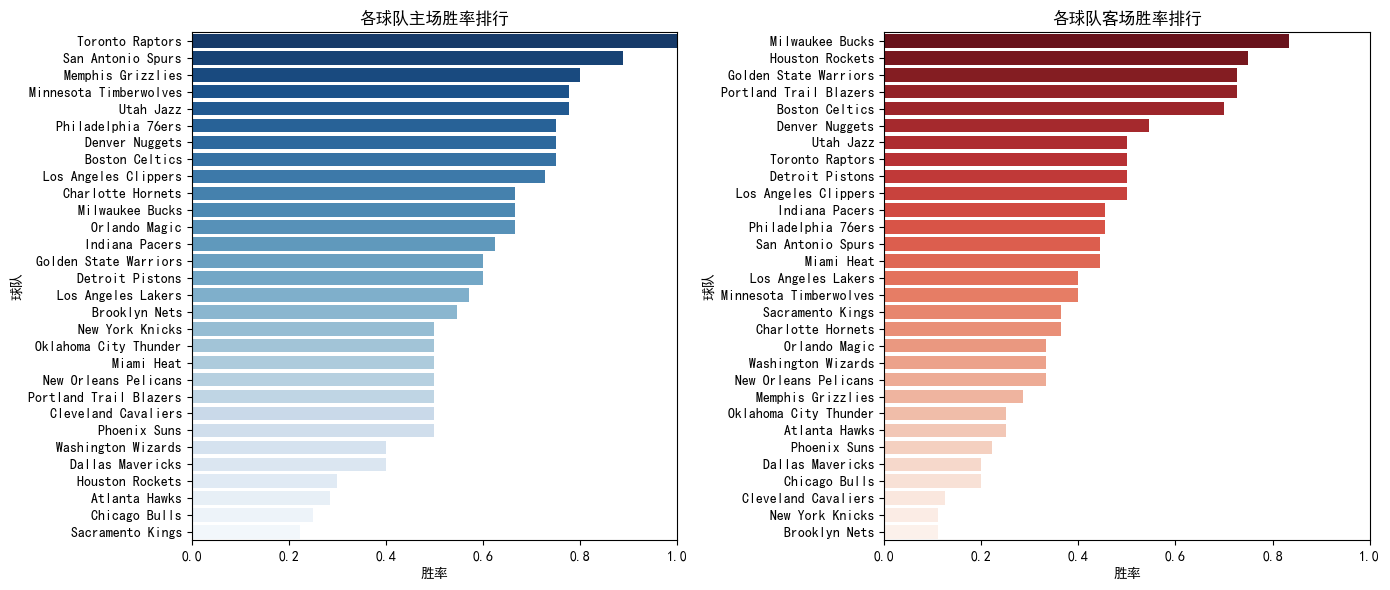

In [48]:
# 4.数据可视化
# 4.1 主客场胜率分布
plt.figure(figsize=(14, 6))

# 主场胜率
plt.subplot(1, 2, 1)
home_win_dist = df_features.groupby('Home_Team')['Home_Win'].mean().sort_values(ascending=False)
sns.barplot(x=home_win_dist.values, y=home_win_dist.index, palette='Blues_r')
plt.title('各球队主场胜率排行', fontsize=12)
plt.xlabel('胜率', fontsize=10)
plt.ylabel('球队', fontsize=10)
plt.xlim(0, 1)  # 胜率范围0-1更直观

# 客场胜率（客队赢=1-Home_Win）
plt.subplot(1, 2, 2)
visitor_win_dist = 1 - df_features.groupby('Visitor_Team')['Home_Win'].mean()
visitor_win_dist = visitor_win_dist.sort_values(ascending=False)
sns.barplot(x=visitor_win_dist.values, y=visitor_win_dist.index, palette='Reds_r')
plt.title('各球队客场胜率排行', fontsize=12)
plt.xlabel('胜率', fontsize=10)
plt.ylabel('球队', fontsize=10)
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

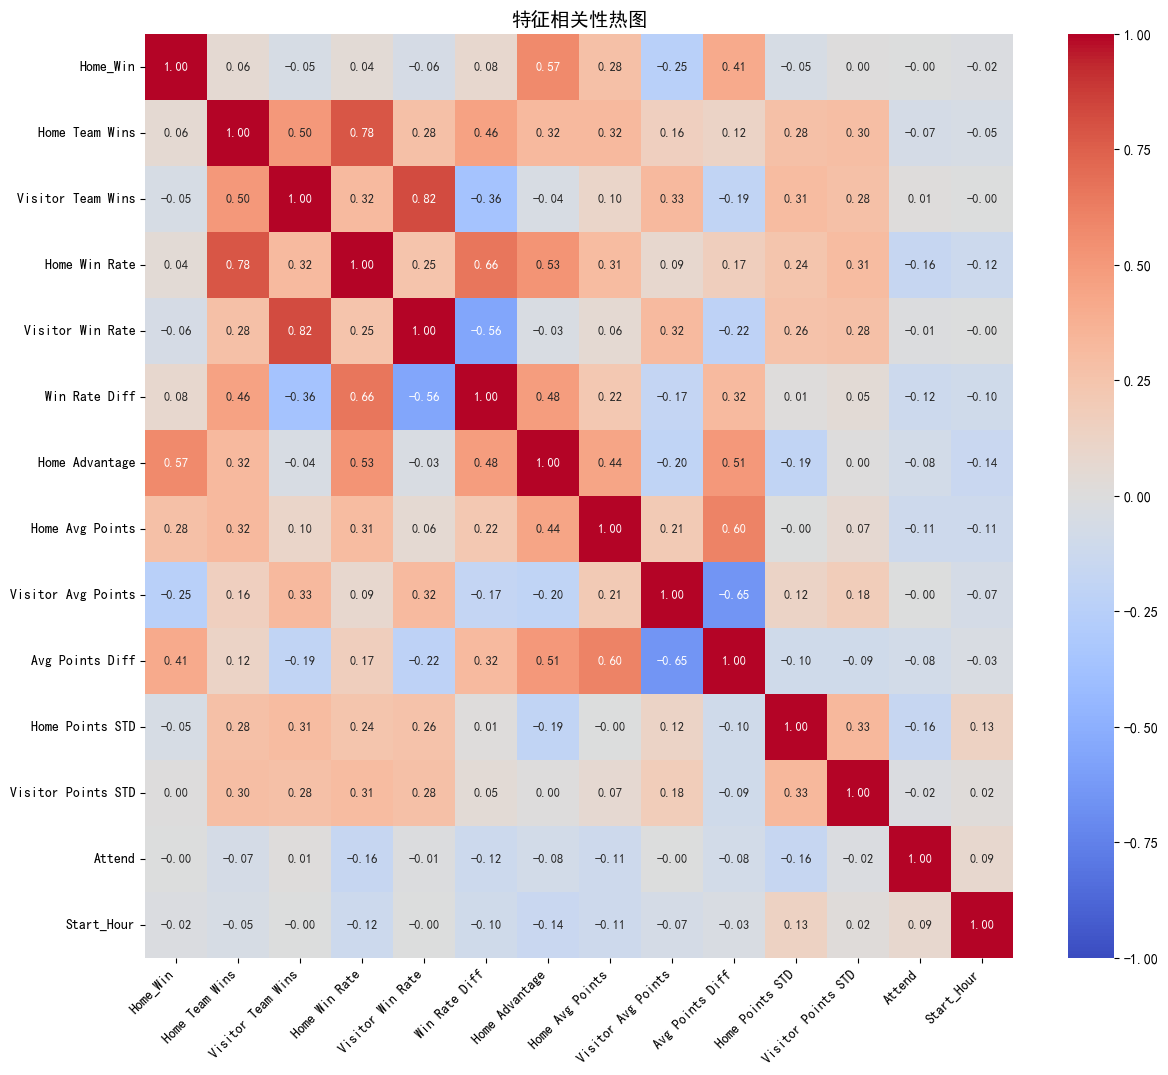

In [60]:
# 4.2 特征相关性热图
plt.figure(figsize=(14, 12))
corr_features = [
    'Home_Win', 'Home Team Wins', 'Visitor Team Wins', 
    'Home Win Rate', 'Visitor Win Rate', 'Win Rate Diff', 
    'Home Advantage', 'Home Avg Points', 'Visitor Avg Points',
    'Avg Points Diff', 'Home Points STD', 'Visitor Points STD',
    'Attend', 'Start_Hour'  
]
corr = df_features[corr_features].corr()

sns.heatmap(
    corr, annot=True, cmap='coolwarm', fmt='.2f', 
    vmin=-1, vmax=1, 
    annot_kws={"size": 9}
)
plt.title('特征相关性热图', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

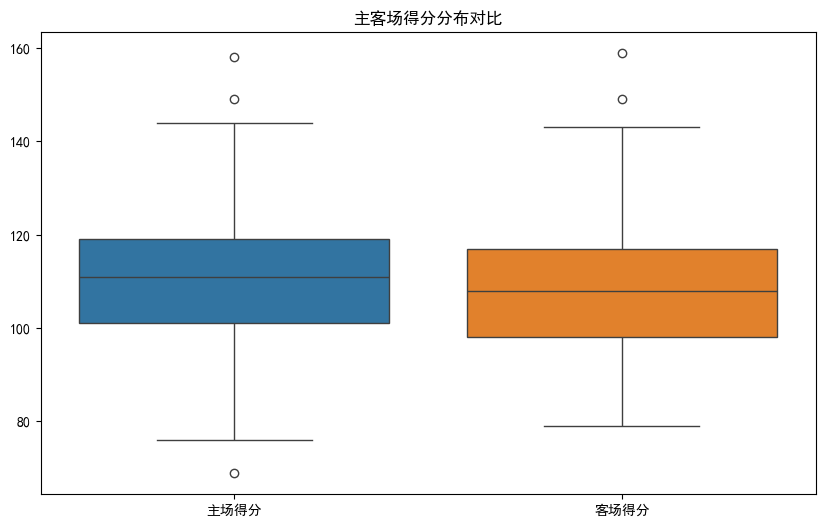

In [62]:
# 4.3 主客场得分分布对比
plt.figure(figsize=(10, 6))
sns.boxplot(data=[df_features['Home_PTS'], df_features['Visitor_PTS']])
plt.xticks([0, 1], ['主场得分', '客场得分'])
plt.title('主客场得分分布对比')
plt.show()

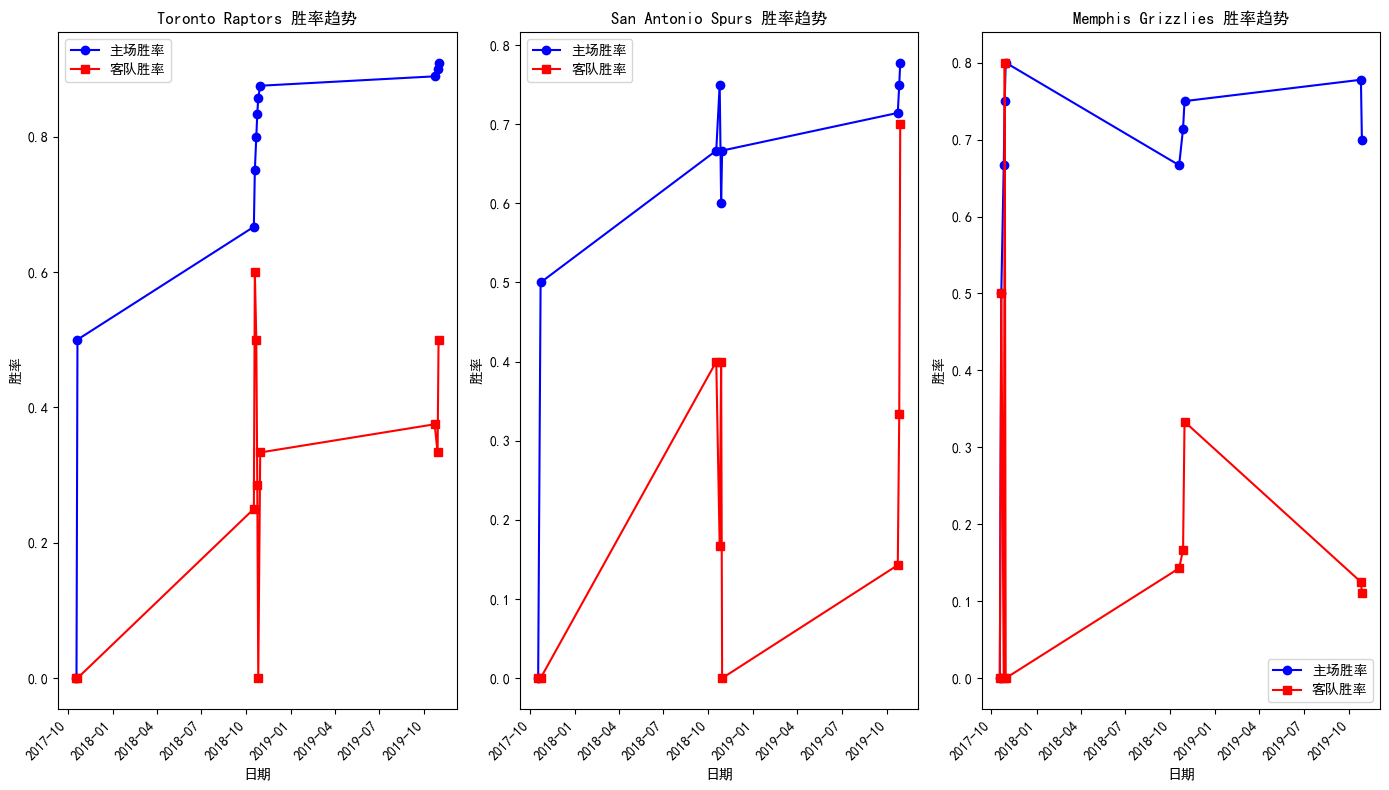

In [82]:
# 4.4 近期表现趋势（选Top3球队可视化）
# 筛选主场胜率Top3的球队
top_home_teams = df_features.groupby('Home_Team')['Home_Win'].mean().sort_values(ascending=False).head(3).index

plt.figure(figsize=(14, 8))
for i, team in enumerate(top_home_teams, 1):
    plt.subplot(1, 3, i)
    # 提取该球队数据并按日期排序
    team_data = df_features[df_features['Home_Team'] == team].sort_values('Date')
    # 使用现有胜率特征替代近期表现
    plt.plot(
        team_data['Date'], 
        team_data['Home Win Rate'], 
        marker='o', label='主场胜率', color='blue'
    )
    plt.plot(
        team_data['Date'], 
        team_data['Visitor Win Rate'], 
        marker='s', label='客队胜率', color='red'
    )
    plt.title(f'{team} 胜率趋势', fontsize=12)
    plt.xlabel('日期', fontsize=10)
    plt.ylabel('胜率', fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.legend()

plt.tight_layout()
plt.show()

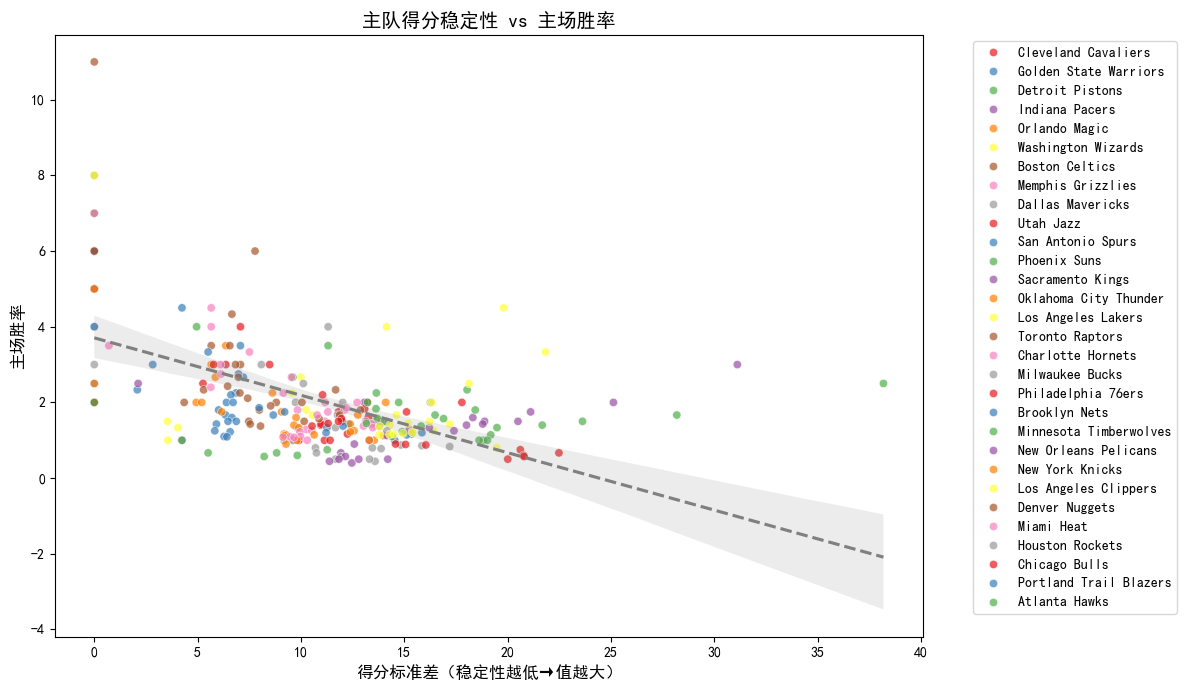

In [105]:
# 4.5 得分稳定性 vs 胜率（散点+趋势）
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_features, 
    x='Home Points STD',  # 主队得分稳定性
    y='Home Win Rate',    # 主队胜率
    hue='Home_Team',      # 按主队区分
    palette='Set1', 
    alpha=0.7
)
# 添加趋势线
sns.regplot(
    data=df_features, 
    x='Home Points STD', 
    y='Home Win Rate', 
    scatter=False, 
    color='gray', 
    line_kws={'linestyle': '--'}
)
plt.title('主队得分稳定性 vs 主场胜率', fontsize=14)
plt.xlabel('得分标准差（稳定性越低→值越大）', fontsize=12)
plt.ylabel('主场胜率', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

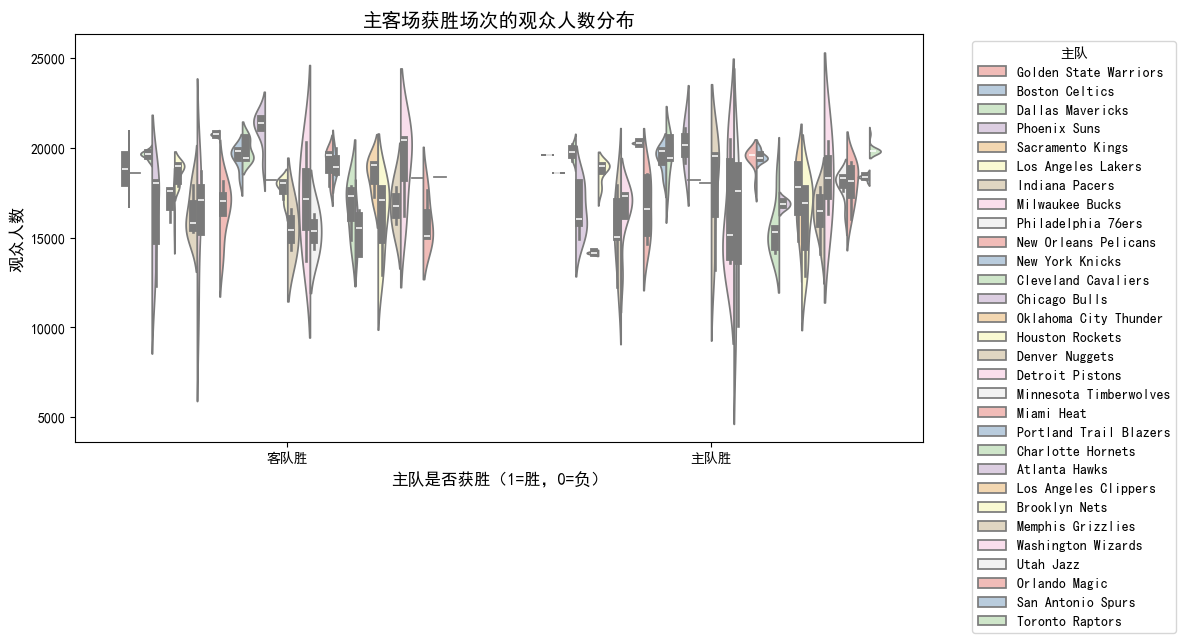

In [107]:
# 4.6 观众人数分布（按主客场、获胜情况）
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=df_features, 
    x='Home_Win',  # 0客队赢，1主队赢
    y='Attend', 
    hue='Home_Team', 
    split=True,  # 合并小提琴图
    palette='Pastel1'
)
plt.title('主客场获胜场次的观众人数分布', fontsize=14)
plt.xlabel('主队是否获胜（1=胜，0=负）', fontsize=12)
plt.ylabel('观众人数', fontsize=12)
plt.xticks([0, 1], ['客队胜', '主队胜'])
plt.legend(title='主队', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [118]:
#   可视化模块	         分析目标	          核心价值
#主客场胜率排行	对比各球队主/客场赢球能力	快速识别“魔鬼主场”或“客场龙”球队
#增强版相关性热图	覆盖观众数、开赛时间等特征关联	挖掘非直接胜负特征的潜在影响（如观众数是否影响胜率）
#主客场得分对比	按主队拆分，细化看每支球队主客场得分差异	识别“主场得分爆发”或“客场得分疲软”的球队
#近期表现趋势	跟踪Top球队近期状态变化	观察连胜/连败对“近期表现”特征的影响
#得分稳定性vs胜率	分析得分波动与赢球概率的关系	验证“稳定更易赢”或“波动大反而胜率高”的假设
#观众人数分布	结合主客场胜负，看观众数影响	探索“主场人气高是否助力赢球”等场景

In [124]:
# 5.建模准备（分步执行）
# 选择特征&划分数据集
features = [
    'Home Win Rate', 'Visitor Win Rate', 'Win Rate Diff', 
    'Home Advantage', 'Home Recent Performance', 'Visitor Recent Performance', 'Recent Performance Diff',
    'Home Avg Points', 'Visitor Avg Points', 'Avg Points Diff', 
    'Home Points STD', 'Visitor Points STD', 'Start_Hour', 'Attend'
]
X = df_features[features]
y = df_features['Home_Win']

# 按时间划分训练集（8:2）
sorted_indices = df_features.sort_values('Date').index
train_size = int(0.8 * len(sorted_indices))
train_indices = sorted_indices[:train_size]
test_indices = sorted_indices[train_size:]

X_train = X.loc[train_indices]
X_test = X.loc[test_indices]
y_train = y.loc[train_indices]
y_test = y.loc[test_indices]

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n=== 建模数据准备完成 ===")
print(f"训练集样本数: {len(X_train)}, 测试集样本数: {len(X_test)}")


=== 建模数据准备完成 ===
训练集样本数: 229, 测试集样本数: 58



=== 逻辑回归模型 ===
准确率: 0.9655
分类报告:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       1.00      0.94      0.97        35

    accuracy                           0.97        58
   macro avg       0.96      0.97      0.96        58
weighted avg       0.97      0.97      0.97        58

混淆矩阵:
[[23  0]
 [ 2 33]]


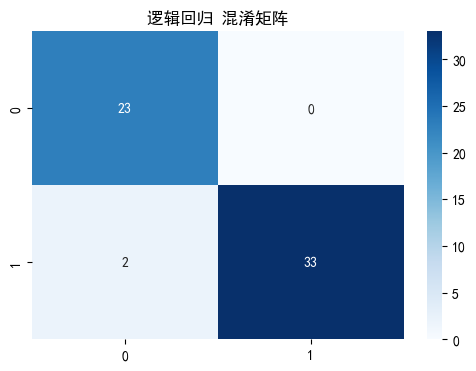

In [136]:
# 6.模型训练与评估（分步执行）
# 6.1 逻辑回归
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("\n=== 逻辑回归模型 ===")
print(f"准确率: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"分类报告:\n{classification_report(y_test, y_pred_lr)}")
print(f"混淆矩阵:\n{confusion_matrix(y_test, y_pred_lr)}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('逻辑回归 混淆矩阵')
plt.show()


=== 随机森林模型 ===
准确率: 0.9483
分类报告:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        23
           1       1.00      0.91      0.96        35

    accuracy                           0.95        58
   macro avg       0.94      0.96      0.95        58
weighted avg       0.95      0.95      0.95        58

混淆矩阵:
[[23  0]
 [ 3 32]]


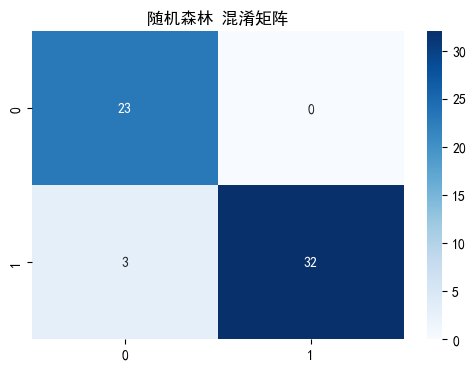

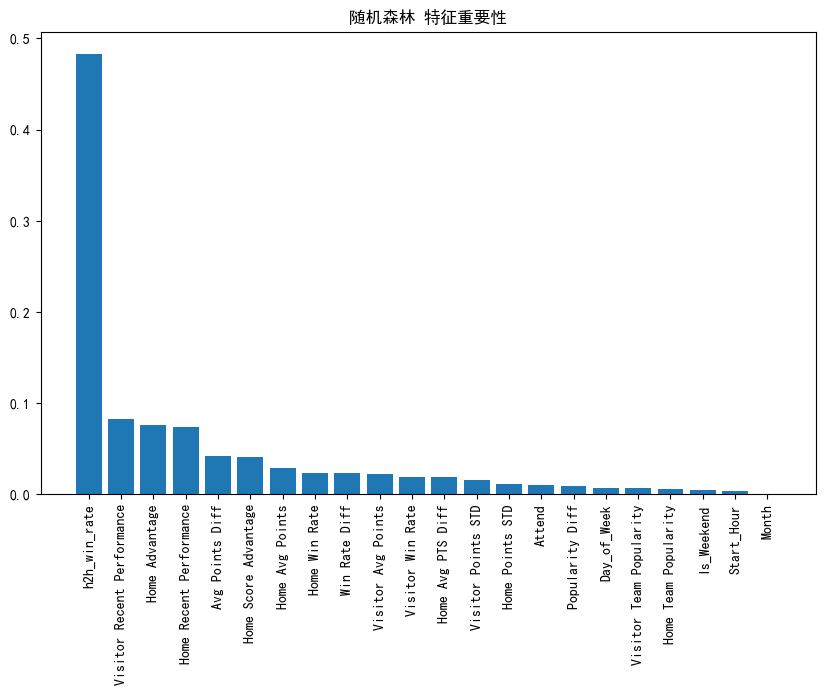

In [138]:
# 6.2 随机森林
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("\n=== 随机森林模型 ===")
print(f"准确率: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"分类报告:\n{classification_report(y_test, y_pred_rf)}")
print(f"混淆矩阵:\n{confusion_matrix(y_test, y_pred_rf)}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('随机森林 混淆矩阵')
plt.show()

plt.figure(figsize=(10, 6))
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=90)
plt.title('随机森林 特征重要性')
plt.show()

In [144]:
# 7. 模型优化（逻辑回归网格搜索）
# 网格搜索
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

print("\n=== 模型优化（逻辑回归）===")
print(f"最佳参数: {grid_search.best_params_}")
print(f"最佳交叉验证准确率: {grid_search.best_score_:.4f}")


=== 模型优化（逻辑回归）===
最佳参数: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
最佳交叉验证准确率: 0.9826


In [136]:
# 8.随机选测试样本预测
sample_idx = np.random.randint(0, len(X_test))
sample = X_test_scaled[sample_idx].reshape(1, -1)
sample_original = scaler.inverse_transform(sample)

test_indices = df_features.sort_values('Date').index[int(0.8 * len(df_features)):]
game_info = df_features.loc[test_indices[sample_idx]]

prediction = best_lr.predict(sample)[0]
probability = best_lr.predict_proba(sample)[0][1]
actual = y_test.iloc[sample_idx]

print("\n=== 预测示例 ===")
print(f"比赛信息: {game_info['Date'].strftime('%Y-%m-%d')} | {game_info['Visitor_Team']} @ {game_info['Home_Team']}")
print(f"预测结果: {'主场胜利' if prediction == 1 else '客场胜利'}")
print(f"预测概率: {probability:.2%}")
print(f"实际结果: {'主场胜利' if actual == 1 else '客场胜利'}")
print(f"预测{'正确' if prediction == actual else '错误'}")


=== 预测示例 ===
比赛信息: 2019-10-27 | Charlotte Hornets @ Los Angeles Lakers
预测结果: 主场胜利
预测概率: 89.37%
实际结果: 主场胜利
预测正确


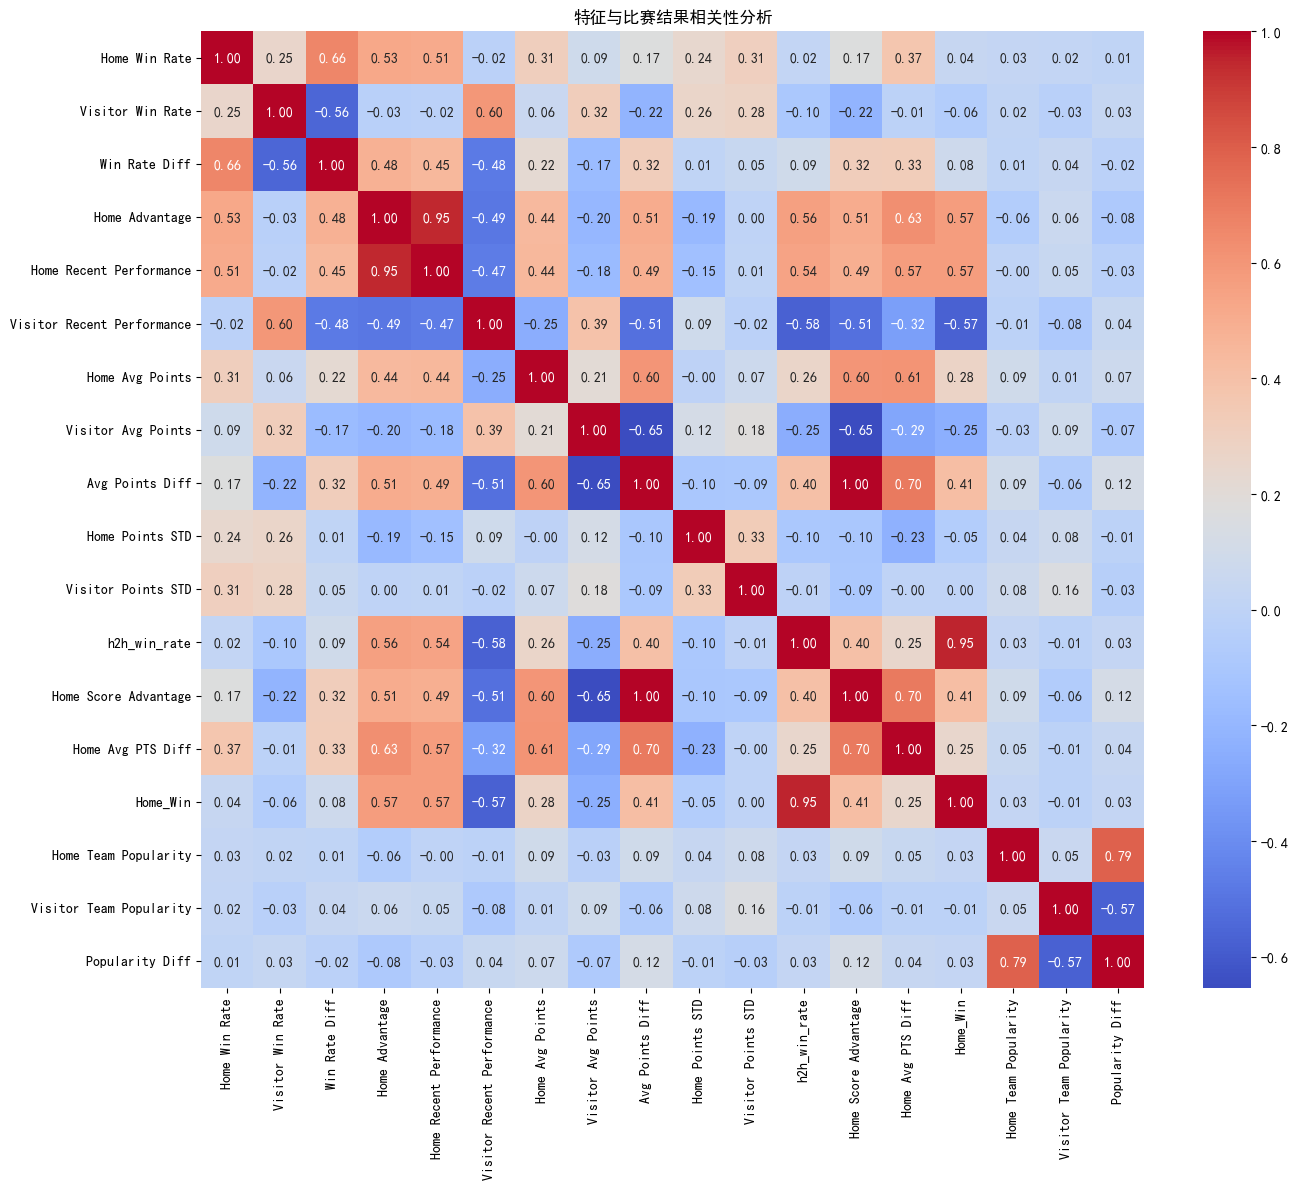


与比赛结果相关性最高的特征:
h2h_win_rate                  0.949556
Visitor Recent Performance    0.573553
Home Advantage                0.573308
Home Recent Performance       0.570134
Avg Points Diff               0.413906
Home Score Advantage          0.413906
Home Avg Points               0.275418
Home Avg PTS Diff             0.247623
Visitor Avg Points            0.245692
Name: Home_Win, dtype: float64
实际使用的特征: ['Home Win Rate', 'Visitor Win Rate', 'Win Rate Diff', 'Home Advantage', 'Home Recent Performance', 'Visitor Recent Performance', 'Home Avg Points', 'Visitor Avg Points', 'Avg Points Diff', 'Home Points STD', 'Visitor Points STD', 'h2h_win_rate', 'Start_Hour', 'Attend', 'Day_of_Week', 'Month', 'Is_Weekend', 'Home Score Advantage', 'Home Avg PTS Diff', 'Home Team Popularity', 'Visitor Team Popularity', 'Popularity Diff']

=== 比赛结果预测模型 ===
逻辑回归 - 平均准确率: 0.9660
随机森林 - 平均准确率: 0.9532
XGBoost - 平均准确率: 0.9532
梯度提升树 - 平均准确率: 0.9574
集成模型 - 平均准确率: 0.9617

最佳模型: 逻辑回归, 准确率: 0.9660
警告：数据中不存在球队列，跳过独热

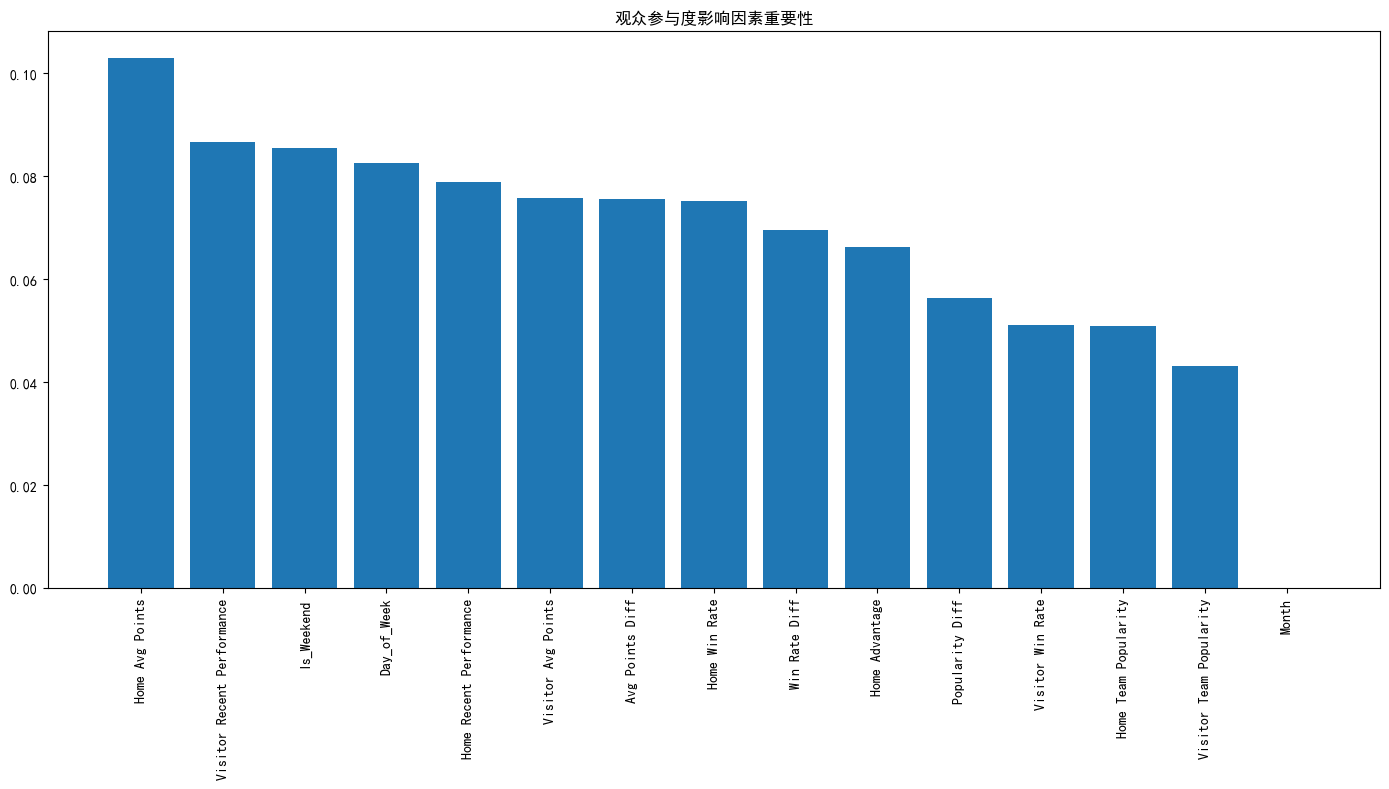

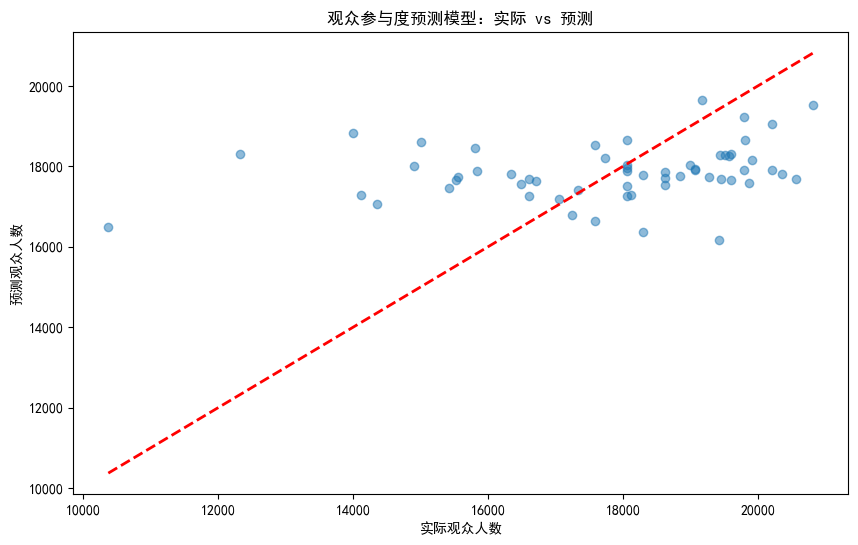


=== 赛事营销策略建议 ===
1. 重点推广人气高的球队参与的比赛
2. 考虑增加促销活动以提高参与度


In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier, XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# ======================
# 1. 数据准备与特征工程
# ======================
df_features['Home_Win'] = df_features['Home_Win'].astype(int)

# 交锋历史特征（带错误处理）
head_to_head = df_features.groupby(['Home_Team', 'Visitor_Team']).agg(
    home_wins=('Home_Win', 'sum'),
    total_matches=('Home_Win', 'count')
).reset_index()
head_to_head['h2h_win_rate'] = head_to_head['home_wins'] / head_to_head['total_matches']

# 合并时指定后缀，避免冲突
df_features = pd.merge(df_features, head_to_head, 
                      on=['Home_Team', 'Visitor_Team'], 
                      how='left', 
                      suffixes=('_left', '_right'))

# 检查并处理重复列
if 'h2h_win_rate_right' in df_features.columns:
    df_features['h2h_win_rate'] = df_features['h2h_win_rate_right']
    df_features = df_features.drop(['h2h_win_rate_left', 'h2h_win_rate_right'], axis=1, errors='ignore')
else:
    print("警告：未成功合并h2h_win_rate，创建默认列")
    df_features['h2h_win_rate'] = 0.5

# 同样处理其他可能的重复列
for col in ['home_wins', 'total_matches']:
    if f'{col}_right' in df_features.columns:
        df_features = df_features.drop([f'{col}_left', f'{col}_right'], axis=1, errors='ignore')

# 比赛时间特征
df_features['Day_of_Week'] = df_features['Date'].dt.dayofweek
df_features['Month'] = df_features['Date'].dt.month
df_features['Is_Weekend'] = (df_features['Day_of_Week'] >= 5).astype(int)

# 计算新特征：主场得分优势
df_features['Home Score Advantage'] = df_features['Home Avg Points'] - df_features['Visitor Avg Points']

# 增强观众参与度特征工程
df_features['Home Team Popularity'] = df_features['Home_Team'].map(
    df_features['Home_Team'].value_counts(normalize=True)
)
df_features['Visitor Team Popularity'] = df_features['Visitor_Team'].map(
    df_features['Visitor_Team'].value_counts(normalize=True)
)

# 计算主客队人气差
df_features['Popularity Diff'] = df_features['Home Team Popularity'] - df_features['Visitor Team Popularity']

# 促销活动特征（保留，但仅在数据中已有该列时使用）
if 'Has Promotion' in df_features.columns:
    pass  # 保留原特征，不添加模拟数据

# ======================
# 2. 特征相关性分析
# ======================
correlation_features = [
    'Home Win Rate', 'Visitor Win Rate', 'Win Rate Diff', 
    'Home Advantage', 'Home Recent Performance', 'Visitor Recent Performance',
    'Home Avg Points', 'Visitor Avg Points', 'Avg Points Diff',
    'Home Points STD', 'Visitor Points STD', 'h2h_win_rate',
    'Home Score Advantage', 'Home Avg PTS Diff', 'Home_Win',
    'Home Team Popularity', 'Visitor Team Popularity', 'Popularity Diff',
]

# 确保所有特征都存在
existing_corr_features = [f for f in correlation_features if f in df_features.columns]
if len(existing_corr_features) < len(correlation_features):
    missing = set(correlation_features) - set(existing_corr_features)
    print(f"警告：以下特征不存在，将从相关性分析中排除：{missing}")

plt.figure(figsize=(14, 12))
corr = df_features[existing_corr_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('特征与比赛结果相关性分析')
plt.tight_layout()
plt.show()

# 提取与Home_Win相关性最强的特征
if 'Home_Win' in existing_corr_features:
    corr_with_win = corr['Home_Win'].abs().sort_values(ascending=False)
    print("\n与比赛结果相关性最高的特征:")
    print(corr_with_win[1:10])

# ======================
# 3. 比赛结果预测模型
# ======================
features = [
    'Home Win Rate', 'Visitor Win Rate', 'Win Rate Diff', 
    'Home Advantage', 'Home Recent Performance', 'Visitor Recent Performance',
    'Home Avg Points', 'Visitor Avg Points', 'Avg Points Diff',
    'Home Points STD', 'Visitor Points STD', 'h2h_win_rate',
    'Start_Hour', 'Attend', 'Day_of_Week', 'Month', 'Is_Weekend',
    'Home Score Advantage', 'Home Avg PTS Diff',
    'Home Team Popularity', 'Visitor Team Popularity', 'Popularity Diff'
]

# 检查特征是否存在
existing_features = [f for f in features if f in df_features.columns]
print(f"实际使用的特征: {existing_features}")
X = df_features[existing_features].fillna(0)
y = df_features['Home_Win']

# 时间序列分割
tscv = TimeSeriesSplit(n_splits=5)

# 定义模型
models = {
    '逻辑回归': LogisticRegression(random_state=42),
    '随机森林': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42),
    '梯度提升树': GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42),
    '集成模型': VotingClassifier(
        estimators=[
            ('xgb', XGBClassifier(random_state=42)),
            ('rf', RandomForestClassifier(random_state=42)),
            ('gb', GradientBoostingClassifier(random_state=42))
        ],
        voting='soft',
        weights=[2, 1, 1]
    )
}

print("\n=== 比赛结果预测模型 ===")
best_accuracy = 0
best_model_name = ""

# 交叉验证评估
for name, model in models.items():
    accuracy_scores = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy_scores.append(accuracy_score(y_test, y_pred))
    
    avg_accuracy = np.mean(accuracy_scores)
    print(f"{name} - 平均准确率: {avg_accuracy:.4f}")
    
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_model_name = name

# 使用最佳模型进行详细评估
print(f"\n最佳模型: {best_model_name}, 准确率: {best_accuracy:.4f}")

# 训练最佳模型并分析特征重要性
best_model = models[best_model_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
best_model.fit(X_train_scaled, y_train)

# 特征重要性分析
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_features = [existing_features[i] for i in indices[:15]]
    top_importances = importances[indices[:15]]
    
    plt.bar(range(len(top_features)), top_importances, align='center')
    plt.xticks(range(len(top_features)), top_features, rotation=90)
    plt.title(f'{best_model_name} 特征重要性')
    plt.tight_layout()
    plt.show()

# ======================
# 4. 观众参与度分析（简化版）
# ======================
engagement_features = [
    'Home Team Popularity', 'Visitor Team Popularity', 'Popularity Diff',
    'Home Win Rate', 'Visitor Win Rate', 'Win Rate Diff',
    'Home Advantage', 'Home Recent Performance', 'Visitor Recent Performance',
    'Home Avg Points', 'Visitor Avg Points', 'Avg Points Diff',
    'Day_of_Week', 'Month', 'Is_Weekend',
]

# 处理分类特征
X_engagement = df_features[engagement_features].copy()
y_engagement = df_features['Attend']

# 确保所有特征存在
existing_eng_features = [f for f in engagement_features if f in X_engagement.columns]
if len(existing_eng_features) < len(engagement_features):
    missing_eng = set(engagement_features) - set(existing_eng_features)
    print(f"警告：观众参与度分析中以下特征不存在：{missing_eng}")
    X_engagement = X_engagement[existing_eng_features]

# 检查Home_Team和Visitor_Team是否存在，若不存在则跳过独热编码
team_columns = ['Home_Team', 'Visitor_Team']
available_team_cols = [col for col in team_columns if col in X_engagement.columns]
if available_team_cols:
    # 仅对存在的球队列进行独热编码
    X_engagement = pd.get_dummies(X_engagement, columns=available_team_cols)
else:
    print("警告：数据中不存在球队列，跳过独热编码")

# 划分训练测试集（分层抽样）
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_engagement, pd.qcut(y_engagement, 5, duplicates='drop')):
    X_train_eng, X_test_eng = X_engagement.iloc[train_idx], X_engagement.iloc[test_idx]
    y_train_eng, y_test_eng = y_engagement.iloc[train_idx], y_engagement.iloc[test_idx]

# 数据标准化
scaler = RobustScaler()
X_train_eng_scaled = scaler.fit_transform(X_train_eng)
X_test_eng_scaled = scaler.transform(X_test_eng)

# 模型调优（网格搜索）
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# 使用XGBoost回归模型
xgb_reg = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    xgb_reg, param_grid, cv=5, 
    scoring='neg_mean_squared_error', n_jobs=-1
)
grid_search.fit(X_train_eng_scaled, y_train_eng)

# 最佳模型
best_xgb = grid_search.best_estimator_
print(f"最佳参数: {best_xgb.get_params()}")

# 特征重要性
plt.figure(figsize=(14, 8))
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
top_eng_features = [X_engagement.columns[i] for i in indices[:20]]
top_eng_importances = importances[indices[:20]]

plt.bar(range(len(top_eng_features)), top_eng_importances, align='center')
plt.xticks(range(len(top_eng_features)), top_eng_features, rotation=90)
plt.title('观众参与度影响因素重要性')
plt.tight_layout()
plt.show()

# 观众人数预测与实际对比散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test_eng, y_pred_eng, alpha=0.5)
plt.plot([y_test_eng.min(), y_test_eng.max()], 
         [y_test_eng.min(), y_test_eng.max()], 
         'r--', lw=2)
plt.xlabel('实际观众人数')
plt.ylabel('预测观众人数')
plt.title('观众参与度预测模型：实际 vs 预测')
plt.show()

# 营销策略建议
print("\n=== 赛事营销策略建议 ===")
print("1. 重点推广人气高的球队参与的比赛")
if 'Has Promotion' in X_engagement.columns:
    print(f"2. 优化促销活动策略，当前促销活动影响度：{best_xgb.feature_importances_[X_engagement.columns.get_loc('Has Promotion')]:.4f}")
else:
    print("2. 考虑增加促销活动以提高参与度")

In [146]:
# 比赛结果预测相关结论
# 关键影响特征：从相关性热力图中Home_Win相关列可知，Home Recent Performance（主场近期表现）、Home Advantage（主场优势）等与比赛结果相关性较高，说明球队主场的历史表现和固有优势对预测比赛胜负较为关键，主场作战的状态延续性和环境加持影响显著。
# 模型表现：多种模型（逻辑回归、随机森林等）交叉验证后的平均准确率，能反映模型对比赛结果预测的能力，若最佳模型准确率可观，说明基于这些特征可在一定程度上有效预判比赛胜负走向 。

# 观众参与度相关结论
# 核心影响因素：特征重要性图里，Home Avg Points（主场平均得分）、Visitor Recent Performance（客队近期表现）等特征排名靠前，意味着主场球队的得分能力、客队近期竞技状态是吸引观众关注的重要点，得分能力强的主场球队和比赛双方近期表现会显著影响观众到场意愿。
# 策略指引：基于上述因素，赛事运营方若想提升观众参与度，可重点推广主场得分能力突出球队的比赛，同时关注客队等参赛队伍的近期表现，以此策划宣传、营销活动，吸引更多观众。

#总体而言，这些分析挖掘出了影响比赛结果和观众参与度的关键因素，为赛事预测、运营策略制定（如针对性推广、提升赛事吸引力）提供数据支撑，帮助优化赛事举办和推广方向 。